### 가상공간 source Seongnam_Scenario_1/bin/activate              
### 파이썬 3.13

In [43]:
import numpy as np 
import pandas as pd 
import geopandas as gpd
import json
from shapely.ops import unary_union
import random
import os
import folium 
from requests.adapters import HTTPAdapter 
from urllib3.util.retry import Retry 
from datetime import timedelta
from shapely.geometry import Point 
from ortools.linear_solver import pywraplp 
from tqdm import tqdm 
import pickle
import warnings; warnings.filterwarnings('ignore')
from shapely.geometry import Point, Polygon, MultiPolygon

In [44]:
print(os.getcwd())  # 지금 실행되는 작업 디렉토리

/Users/jung-eunjoo/Desktop/은주/연구/AI_agent/Seongnam_Scenario_1


In [45]:
# 원하는 경로로 변경
os.chdir("/Users/jung-eunjoo/Desktop/은주/연구/AI_agent/Seongnam_Scenario_1")

print("변경 후 작업 디렉토리:", os.getcwd())

변경 후 작업 디렉토리: /Users/jung-eunjoo/Desktop/은주/연구/AI_agent/Seongnam_Scenario_1


In [46]:
boundary_path = "data/etc/seongnam_boundary.geojson"
taxi_path = "raw_data/Seongnam-si/Seongnam_Taxi/(SNRI) TIMS자료_영업별 자료_QUERRY_4월.xlsx"

In [47]:
taxi_df = pd.read_excel(taxi_path)

In [48]:
taxi_df

구분       차량번호  운송사업자 등록번호                결제일시   승차요금  호출요금  기타요금  \
0       일반택시  경기32바1311  1298103840 2024-04-01 00:00:18  18200     0     0   
1       일반택시  경기32바1222  1298108068 2024-04-01 00:00:42  10700     0     0   
2       일반택시  경기32바1484  1298104378 2024-04-01 00:00:46   6200     0     0   
3       일반택시  경기32바1168  6908602687 2024-04-01 00:00:51  14900     0     0   
4       일반택시  경기32바1217  1298108068 2024-04-01 00:01:11   6600     0     0   
...      ...        ...         ...                 ...    ...   ...   ...   
920501  개인택시  경기32바6549  5053659849 2024-04-30 23:56:27   9900     0     0   
920502  개인택시  경기32바6571  1293573882 2024-04-30 23:56:27  15700     0     0   
920503  개인택시  경기32바6559  5024773023 2024-04-30 23:57:58  19600     0     0   
920504  개인택시  경기32바6550  2482300940 2024-04-30 23:58:42  31500     0     0   
920505  개인택시  경기32바6579  1293573994 2024-04-30 23:58:55   7300     0     0   

        할증여부 결제구분(구분불가/현금/카드)                승차시간  ...      승차Y좌표     승차법정동코드  \
0       복합할증               카드 2024-03-31 23:45:04  ...  37.365108  4113510300   
1         할증               현금 2024-03-31 23:47:42  ...  37.412332  4113510700   
2         할증               현금 2024-03-31 23:57:28  ...  37.443192  4113110200   
3       복합할증               현금 2024-03-31 23:48:46  ...  37.432256  4113310100   
4         할증               현금 2024-03-31 23:58:06  ...  37.431717  4113310100   
...      ...              ...                 ...  ...        ...         ...   
920501    할증               카드 2024-04-30 23:48:17  ...  37.432236  4113310100   
920502    할증               카드 2024-04-30 23:44:26  ...  37.412343  4113510700   
920503  복합할증               카드 2024-04-30 23:35:23  ...  37.388985  4113510600   
920504  복합할증               현금 2024-04-30 23:37:09  ...  37.396114  4113510900   
920505    할증               현금 2024-04-30 23:52:59  ...  37.433331  4113310100   

                      하차시간       하차X좌표      하차Y좌표     하차법정동코드   승차거리(m)  \
0      2024-04-01 00:00:16  127.101891  37.273411  4146310100  11350.52   
1      2024-04-01 00:00:29  127.140384  37.439912  4113110100   4277.42   
2      2024-04-01 00:00:21  127.138474  37.442848  4113110100    306.26   
3      2024-04-01 00:00:37  127.209299  37.435588  4161010600   9671.19   
4      2024-04-01 00:01:04  127.143590  37.437508  4113310100   1597.36   
...                    ...         ...        ...         ...       ...   
920501 2024-04-30 23:56:22  127.158615  37.458549  4113110400   4533.32   
920502 2024-04-30 23:56:18  127.214953  37.411350  4161010800  10710.10   
920503 2024-04-30 23:57:55  127.077309  37.313423  4146510600  11800.53   
920504 2024-04-30 23:58:26  127.016563  37.274731  4111512500  23283.36   
920505 2024-04-30 23:58:38  127.146819  37.441139  4113110100   1852.01   

        승차전빈차거리(m)  승차시간(sec)     결제연월일  
0          3029.30        912  20240401  
1           516.18        767  20240401  
2          2876.95        173  20240401  
3          1488.16        711  20240401  
4          4528.09        178  20240401  
...            ...        ...       ...  
920501    27026.56        485  20240430  
920502      515.14        712  20240430  
920503     6285.55       1352  20240430  
920504     3594.53       1277  20240430  
920505      219.25        339  20240430  

[920506 rows x 21 columns]

#### 이상치 제거

In [49]:
df = taxi_df
# 정상 범위 (대한민국 위도/경도)
valid_lat = (33, 39)
valid_lon = (124, 132)

# 승차/하차 정상 범위 여부
mask_pickup_ok = (
    (df["승차Y좌표"].between(*valid_lat)) &
    (df["승차X좌표"].between(*valid_lon)) &
    (df["승차Y좌표"] != 0) & (df["승차X좌표"] != 0)
)

mask_dropoff_ok = (
    (df["하차Y좌표"].between(*valid_lat)) &
    (df["하차X좌표"].between(*valid_lon)) &
    (df["하차Y좌표"] != 0) & (df["하차X좌표"] != 0)
)

# 둘 다 정상인 행만 남기기
mask_valid = mask_pickup_ok & mask_dropoff_ok
taxi_df = df.loc[mask_valid].copy()

print("원본:", len(df), "행")
print("정상 좌표만:", len(taxi_df), "행")
print("제거된 이상치:", len(df) - len(taxi_df), "행")

원본: 920506 행
정상 좌표만: 917823 행
제거된 이상치: 2683 행


In [50]:
# 제거된 이상치만 보기
removed_outliers = df.loc[~mask_valid, [
    "승차시간","차량번호",
    "승차Y좌표","승차X좌표",
    "하차Y좌표","하차X좌표",
    "승차전빈차거리(m)"
]]

print("제거된 이상치 건수:", len(removed_outliers))
display(removed_outliers)

제거된 이상치 건수: 2683


승차시간       차량번호  승차Y좌표  승차X좌표      하차Y좌표       하차X좌표  \
70     2024-04-01 00:12:47  경기32바1275    0.0    0.0  37.458412  127.163457   
1167   2024-04-01 11:20:53  경기32바1465    0.0    0.0  37.532913  127.128098   
1219   2024-04-01 12:14:45  경기32바1482    0.0    0.0  37.364574  127.105865   
1608   2024-04-01 17:26:18  경기32바1454    0.0    0.0  37.442600  127.151360   
2357   2024-04-01 22:39:57  경기32바1145    0.0    0.0  37.418768  127.130344   
...                    ...        ...    ...    ...        ...         ...   
919705 2024-04-30 10:43:57  경기32바6541    0.0    0.0  37.450331  127.166050   
919770 2024-04-30 11:44:47  경기32바6595    0.0    0.0   0.000000    0.000000   
920002 2024-04-30 15:02:34  경기32바6575    0.0    0.0  37.466000  127.136496   
920102 2024-04-30 17:06:31  경기32바6610    0.0    0.0  37.436316  127.133914   
920310 2024-04-30 21:00:41  경기32바6550    0.0    0.0  37.391342  127.125366   

        승차전빈차거리(m)  
70          454.58  
1167        648.44  
1219       1987.89  
1608        435.55  
2357        141.33  
...            ...  
919705      592.26  
919770        0.00  
920002      315.71  
920102     1061.37  
920310      549.41  

[2683 rows x 7 columns]

### 호출시간 컬럼 생성해보기 (정확하지 않아서 사용해도 될지....)

In [51]:
import pandas as pd
df = taxi_df 

# 평균속도 (m/s) : 35 km/h = (35*1000)/3600 ≈ 9.72
avg_speed = 35 * 1000 / 3600  

# 숫자형 변환 (혹시 문자열/결측 있으면 NaN으로)
df["승차전빈차거리(m)"] = pd.to_numeric(df["승차전빈차거리(m)"], errors="coerce")

# 예상 대기시간(초) = 빈차거리 / 평균속도
df["예상대기시간(초)"] = df["승차전빈차거리(m)"] / avg_speed

# 예비 호출시간 = 승차시간 - 예상대기시간
df["예비호출시간"] = df["승차시간"] - pd.to_timedelta(df["예상대기시간(초)"], unit="s")

# 확인
print(df[["승차시간","승차전빈차거리(m)","예상대기시간(초)","예비호출시간"]].head(10))

                 승차시간  승차전빈차거리(m)   예상대기시간(초)                        예비호출시간
0 2024-03-31 23:45:04     3029.30  311.585143 2024-03-31 23:39:52.414857143
1 2024-03-31 23:47:42      516.18   53.092800 2024-03-31 23:46:48.907200000
2 2024-03-31 23:57:28     2876.95  295.914857 2024-03-31 23:52:32.085142857
3 2024-03-31 23:48:46     1488.16  153.067886 2024-03-31 23:46:12.932114286
4 2024-03-31 23:58:06     4528.09  465.746400 2024-03-31 23:50:20.253600000
5 2024-03-31 23:58:40     1290.62  132.749486 2024-03-31 23:56:27.250514286
6 2024-04-01 00:01:47     5994.14  616.540114 2024-03-31 23:51:30.459885714
7 2024-03-31 23:57:05      485.38   49.924800 2024-03-31 23:56:15.075200000
8 2024-03-31 23:54:13     1599.80  164.550857 2024-03-31 23:51:28.449142857
9 2024-03-31 23:57:25     9648.34  992.400686 2024-03-31 23:40:52.599314286


#### 이상치 추출 위해 시각화

In [52]:
import folium

# 1) 이상치 행만 추출 (예: 100km 이상)
outlier_df = taxi_df.loc[taxi_df["승차전빈차거리(m)"] > 100_000].copy()

# 좌표를 숫자로 변환
outlier_df["승차X좌표"] = pd.to_numeric(outlier_df["승차X좌표"], errors="coerce")
outlier_df["승차Y좌표"] = pd.to_numeric(outlier_df["승차Y좌표"], errors="coerce")
outlier_df["하차X좌표"] = pd.to_numeric(outlier_df["하차X좌표"], errors="coerce")
outlier_df["하차Y좌표"] = pd.to_numeric(outlier_df["하차Y좌표"], errors="coerce")

# 2) 중심 좌표 (성남시청 근처)
m = folium.Map(location=[37.4200, 127.1265], zoom_start=11)

# 3) 각 행별로 출발/하차 마커 추가
for _, row in outlier_df.iterrows():
    pickup = (row["승차Y좌표"], row["승차X좌표"])
    drop   = (row["하차Y좌표"], row["하차X좌표"])

    # 승차 위치 (파란색)
    folium.CircleMarker(
        pickup, radius=4, color="blue", fill=True, fill_color="blue",
        popup=f"차량 {row['차량번호']} 승차시간 {row['승차시간']}"
    ).add_to(m)

    # 하차 위치 (빨간색)
    folium.CircleMarker(
        drop, radius=4, color="red", fill=True, fill_color="red",
        popup=f"차량 {row['차량번호']} 하차시간 {row['하차시간']}"
    ).add_to(m)

    # 승차→하차 라인
    folium.PolyLine([pickup, drop], color="gray", weight=1, opacity=0.5).add_to(m)

# 4) 저장
m


#### 성남시 택시는 승차는 성남 하차는 어디든 상관없음 -> 그러니까 하차가 성남 경계 아닌 행 제거

In [53]:
# 0) 경계 파일 경로
# 1) 좌표 숫자형으로 보장
for col in ["승차X좌표","승차Y좌표","하차X좌표","하차Y좌표"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# (선택) 대한민국 대략 범위로 1차 프리필터 → 성능 향상
valid_lat = (33, 39)
valid_lon = (124, 132)
pre_mask = (
    df["승차Y좌표"].between(*valid_lat) &
    df["승차X좌표"].between(*valid_lon) &
    (df["승차Y좌표"] != 0) & (df["승차X좌표"] != 0)
)
df_pre = df.loc[pre_mask].copy()

# 2) 성남시 경계 로드 (WGS84 가정: lon/lat)
sgn = gpd.read_file(boundary_path)
# 멀티폴리곤 등 결합
sgn_geom = unary_union(sgn.geometry.values)
sgn_gdf = gpd.GeoDataFrame(geometry=[sgn_geom], crs="EPSG:4326")

# 3) 승차 포인트 GeoDataFrame 생성 (lon, lat 순서 주의!)
pickup_gdf = gpd.GeoDataFrame(
    df_pre,
    geometry=gpd.points_from_xy(df_pre["승차X좌표"], df_pre["승차Y좌표"]),
    crs="EPSG:4326"
)

# 4) 공간조인으로 성남시 내부 여부 판정
# predicate='within' 또는 'intersects' 사용 가능 (경계선 포함하려면 'intersects')
joined = gpd.sjoin(pickup_gdf, sgn_gdf, how="left", predicate="within")
mask_pickup_in_seongnam = joined["index_right"].notna()

# 5) 결과 분리 (geometry 제거는 pickup_gdf 기준으로만 필요함)
df_pickup_in  = df_pre.loc[mask_pickup_in_seongnam].copy()
df_pickup_out = df_pre.loc[~mask_pickup_in_seongnam].copy()

print("원본 행수:", len(df))
print("프리필터 통과(대한민국 범위·0,0 제외):", len(df_pre))
print("승차지 성남 내부:", len(df_pickup_in))
print("승차지 성남 외부:", len(df_pickup_out))


원본 행수: 917823
프리필터 통과(대한민국 범위·0,0 제외): 917823
승차지 성남 내부: 847652
승차지 성남 외부: 70171


In [54]:
inside = len(df_pickup_in)
outside = len(df_pickup_out)
total = len(df_pre)
print(f"inside: {inside} ({inside/total*100:.2f}%)")
print(f"outside: {outside} ({outside/total*100:.2f}%)")

inside: 847652 (92.35%)
outside: 70171 (7.65%)


In [55]:
df = df_pickup_in.copy()

In [56]:
df

구분       차량번호  운송사업자 등록번호                결제일시   승차요금  호출요금  기타요금  \
0       일반택시  경기32바1311  1298103840 2024-04-01 00:00:18  18200     0     0   
1       일반택시  경기32바1222  1298108068 2024-04-01 00:00:42  10700     0     0   
2       일반택시  경기32바1484  1298104378 2024-04-01 00:00:46   6200     0     0   
3       일반택시  경기32바1168  6908602687 2024-04-01 00:00:51  14900     0     0   
4       일반택시  경기32바1217  1298108068 2024-04-01 00:01:11   6600     0     0   
...      ...        ...         ...                 ...    ...   ...   ...   
920501  개인택시  경기32바6549  5053659849 2024-04-30 23:56:27   9900     0     0   
920502  개인택시  경기32바6571  1293573882 2024-04-30 23:56:27  15700     0     0   
920503  개인택시  경기32바6559  5024773023 2024-04-30 23:57:58  19600     0     0   
920504  개인택시  경기32바6550  2482300940 2024-04-30 23:58:42  31500     0     0   
920505  개인택시  경기32바6579  1293573994 2024-04-30 23:58:55   7300     0     0   

        할증여부 결제구분(구분불가/현금/카드)                승차시간  ...                하차시간  \
0       복합할증               카드 2024-03-31 23:45:04  ... 2024-04-01 00:00:16   
1         할증               현금 2024-03-31 23:47:42  ... 2024-04-01 00:00:29   
2         할증               현금 2024-03-31 23:57:28  ... 2024-04-01 00:00:21   
3       복합할증               현금 2024-03-31 23:48:46  ... 2024-04-01 00:00:37   
4         할증               현금 2024-03-31 23:58:06  ... 2024-04-01 00:01:04   
...      ...              ...                 ...  ...                 ...   
920501    할증               카드 2024-04-30 23:48:17  ... 2024-04-30 23:56:22   
920502    할증               카드 2024-04-30 23:44:26  ... 2024-04-30 23:56:18   
920503  복합할증               카드 2024-04-30 23:35:23  ... 2024-04-30 23:57:55   
920504  복합할증               현금 2024-04-30 23:37:09  ... 2024-04-30 23:58:26   
920505    할증               현금 2024-04-30 23:52:59  ... 2024-04-30 23:58:38   

             하차X좌표      하차Y좌표     하차법정동코드   승차거리(m)  승차전빈차거리(m) 승차시간(sec)  \
0       127.101891  37.273411  4146310100  11350.52     3029.30       912   
1       127.140384  37.439912  4113110100   4277.42      516.18       767   
2       127.138474  37.442848  4113110100    306.26     2876.95       173   
3       127.209299  37.435588  4161010600   9671.19     1488.16       711   
4       127.143590  37.437508  4113310100   1597.36     4528.09       178   
...            ...        ...         ...       ...         ...       ...   
920501  127.158615  37.458549  4113110400   4533.32    27026.56       485   
920502  127.214953  37.411350  4161010800  10710.10      515.14       712   
920503  127.077309  37.313423  4146510600  11800.53     6285.55      1352   
920504  127.016563  37.274731  4111512500  23283.36     3594.53      1277   
920505  127.146819  37.441139  4113110100   1852.01      219.25       339   

           결제연월일    예상대기시간(초)                        예비호출시간  
0       20240401   311.585143 2024-03-31 23:39:52.414857143  
1       20240401    53.092800 2024-03-31 23:46:48.907200000  
2       20240401   295.914857 2024-03-31 23:52:32.085142857  
3       20240401   153.067886 2024-03-31 23:46:12.932114286  
4       20240401   465.746400 2024-03-31 23:50:20.253600000  
...          ...          ...                           ...  
920501  20240430  2779.874743 2024-04-30 23:01:57.125257143  
920502  20240430    52.985829 2024-04-30 23:43:33.014171429  
920503  20240430   646.513714 2024-04-30 23:24:36.486285714  
920504  20240430   369.723086 2024-04-30 23:30:59.276914286  
920505  20240430    22.551429 2024-04-30 23:52:36.448571429  

[847652 rows x 23 columns]

 ### 시나리오1_2024-04-18 23:00() ~ 2024-04-19 02:00 (1380~1560)
 ### 이 시간대 승객들만 정제 

### 전처리 코드 정리

| 컬럼명 | 설명 | 데이터 타입 | 비고 |
|--------|------|-------------|------|
| **ID** | 고유 식별자 | int | 0부터 순번 |
| **ride_time** |호출 발생 시각 (누적 분) | int | 기준 자정(2024-04-18 00:00)부터 누적 분 |
| **ride_lat** | 승차 위도 | float | |
| **ride_lon** | 승차 경도 | float |  |
| **alight_lat** | 하차 위도 | float |   |
| **alight_lon** | 하차 경도 | float |   |
| **taxi_type** | 구분 | int |  (개인=0, 일반/법인=1) |
| **dispatch_time** | 배차 시간 | int | 초기 0 → 알고리즘이 배차 확정하면 채움(누적분) |
| **type** | 택시 유형 구분 | int | 기본값 0 (장애인택시 구분 미사용) |


#### 2024-04-18 23:00 <= 승차시간 < 2024-04-20 02:00 이 사이 값들만 추출

In [57]:
import pandas as pd

# 호출시간을 datetime으로 보장
df["승차시간"] = pd.to_datetime(df["승차시간"], errors="coerce")

# 날짜 범위 필터: 2024-04-18 23:00 <= 승차시간 < 2024-04-20 02:00
start = pd.Timestamp("2024-04-18 23:00:00")
end   = pd.Timestamp("2024-04-19 02:00:00")

df_0418_23_0419_02 = df.loc[df["승차시간"].between(start, end - pd.Timedelta(seconds=1))].reset_index(drop=True)

print(df_0418_23_0419_02.shape)
display(df_0418_23_0419_02.head())


(4586, 23)


구분       차량번호  운송사업자 등록번호                결제일시  승차요금  호출요금  기타요금 할증여부  \
0  일반택시  경기32바1282  1298106809 2024-04-18 23:04:33  7500     0     0   할증   
1  일반택시  경기32바1487  1298104378 2024-04-18 23:07:09  9400     0     0   할증   
2  일반택시  경기32바1338  1298103840 2024-04-18 23:07:12  7200     0     0   할증   
3  일반택시  경기32바1198  1298108447 2024-04-18 23:07:23  7500     0     0   할증   
4  일반택시  경기32바1142  6908602687 2024-04-18 23:07:34  8100     0     0   할증   

  결제구분(구분불가/현금/카드)                승차시간  ...                하차시간       하차X좌표  \
0               현금 2024-04-18 23:00:12  ... 2024-04-18 23:04:27  127.144046   
1               카드 2024-04-18 23:00:14  ... 2024-04-18 23:07:03  127.132637   
2               카드 2024-04-18 23:01:37  ... 2024-04-18 23:07:11  127.156380   
3               현금 2024-04-18 23:03:24  ... 2024-04-18 23:07:12  127.158401   
4               현금 2024-04-18 23:03:09  ... 2024-04-18 23:07:21  127.165958   

       하차Y좌표     하차법정동코드  승차거리(m)  승차전빈차거리(m) 승차시간(sec)     결제연월일  \
0  37.447733  4113110100  2499.80      748.31       255  20240418   
1  37.381664  4113510500  4050.85      972.46       409  20240418   
2  37.451626  4113110400  1884.85    38797.27       334  20240418   
3  37.444923  4113310300  2776.79      500.78       228  20240418   
4  37.435277  4113310500  3075.51      538.22       252  20240418   

     예상대기시간(초)                        예비호출시간  
0    76.969029 2024-04-18 22:58:55.030971429  
1   100.024457 2024-04-18 22:58:33.975542857  
2  3990.576343 2024-04-18 21:55:06.423657143  
3    51.508800 2024-04-18 23:02:32.491200000  
4    55.359771 2024-04-18 23:02:13.640228571  

[5 rows x 23 columns]

In [58]:
sub = df_0418_23_0419_02.copy()
sub.columns = [str(c).replace("\x08","").strip() for c in sub.columns]
sub = sub.reset_index(drop=True)

# ride_time = 승차시간 기준 누적분
BASE_DATE_STR = "2024-04-18"
t0 = pd.Timestamp(BASE_DATE_STR).normalize()

sub["승차시간"] = pd.to_datetime(sub["승차시간"], errors="coerce")
ride_time_series = ((sub["승차시간"] - t0).dt.total_seconds() // 60).astype("Int64")
ride_time = ride_time_series.mask(ride_time_series < 0, pd.NA).fillna(0).astype(int)

# taxi_type
def map_taxi_type(v):
    s = ("" if pd.isna(v) else str(v)).strip().lower().replace(" ", "")
    if "개인" in s: return 0
    if ("일반" in s) or ("법인" in s): return 1
    return 1
taxi_type = sub["구분"].map(map_taxi_type).fillna(1).astype(int)

# dispatch_time = 0  (★ sub.index 사용)
dispatch_time = pd.Series(0, index=sub.index, dtype="int64")

# passenger_df
passenger_df = pd.DataFrame({
    "ID": range(len(sub)),
    "ride_time": ride_time,
    "dispatch_time": dispatch_time,
    "ride_lat": pd.to_numeric(sub["승차Y좌표"], errors="coerce"),
    "ride_lon": pd.to_numeric(sub["승차X좌표"], errors="coerce"),
    "alight_lat": pd.to_numeric(sub["하차Y좌표"], errors="coerce"),
    "alight_lon": pd.to_numeric(sub["하차X좌표"], errors="coerce"),
    "taxi_type": taxi_type,
    "type": 0
})
passenger_df = passenger_df.query("1380 <= ride_time <= 1560").reset_index(drop=True)

print(passenger_df.shape)
display(passenger_df.head())

(4586, 9)


ID  ride_time  dispatch_time   ride_lat    ride_lon  alight_lat  \
0   0       1380              0  37.454429  127.161169   37.447733   
1   1       1380              0  37.412327  127.129150   37.381664   
2   2       1381              0  37.446423  127.142220   37.451626   
3   3       1383              0  37.433807  127.134003   37.444923   
4   4       1383              0  37.430250  127.136877   37.435277   

   alight_lon  taxi_type  type  
0  127.144046          1     0  
1  127.132637          1     0  
2  127.156380          1     0  
3  127.158401          1     0  
4  127.165958          1     0

In [59]:
passenger_df

ID  ride_time  dispatch_time   ride_lat    ride_lon  alight_lat  \
0        0       1380              0  37.454429  127.161169   37.447733   
1        1       1380              0  37.412327  127.129150   37.381664   
2        2       1381              0  37.446423  127.142220   37.451626   
3        3       1383              0  37.433807  127.134003   37.444923   
4        4       1383              0  37.430250  127.136877   37.435277   
...    ...        ...            ...        ...         ...         ...   
4581  4581       1540              0  37.379269  127.115352   37.329319   
4582  4582       1547              0  37.416835  127.126573   37.346983   
4583  4583       1551              0  37.412369  127.129059   37.451324   
4584  4584       1558              0  37.409885  127.125549   37.412811   
4585  4585       1550              0  37.397946  127.111095   37.282338   

      alight_lon  taxi_type  type  
0     127.144046          1     0  
1     127.132637          1     0  
2     127.156380          1     0  
3     127.158401          1     0  
4     127.165958          1     0  
...          ...        ...   ...  
4581  127.074205          0     0  
4582  127.113311          0     0  
4583  127.168015          0     0  
4584  127.144676          0     0  
4585  126.978771          0     0  

[4586 rows x 9 columns]

In [60]:
passenger_df.to_csv("data/agents/passenger/passenger_data.csv", index=False)
print("passenger_data.csv 저장 완료 (덮어쓰기됨)")

passenger_data.csv 저장 완료 (덮어쓰기됨)


## 이제 뭐야 택시스케쥴 데이터

| 컬럼명 | 설명 | 데이터 타입 | 비고 |
|--------|------|-------------|------|
| vehicle_id | 차량 고유 식별자 | int | 0부터 순번 |
| taxi_type | 택시 구분 | int | 개인=0, 법인=1 |
| work_start | 근무 시작 시각 (시 단위) | int | 0–24 (정수 시각) |
| work_end | 근무 종료 시각 (시 단위) | int | 0–24 (정수 시각, work_end < work_start면 익일 종료) |
| temporary_stopTime | 일시 정지 시간 | int | 기본값 0 (미사용) |
| lat | 초기 배치 위도 | float | 성남시 경계 내 무작위 배치 |
| lon | 초기 배치 경도 | float | 성남시 경계 내 무작위 배치 |
| cartype | 택시 구분(보류) | int | 기본 0 (사용 안 함) |

In [61]:
import pandas as pd

# 1) 승차시간 datetime 변환
taxi_df["승차시간"] = pd.to_datetime(taxi_df["승차시간"], errors="coerce")

# 2) 심야 시간대 (2024-04-18 23:00 ~ 2024-04-19 02:00) 필터
start = pd.Timestamp("2024-04-18 23:00:00")
end   = pd.Timestamp("2024-04-19 02:00:00")
night_df = taxi_df.loc[taxi_df["승차시간"].between(start, end, inclusive="both")].copy()
print("rows in window (호출 건수):", len(night_df))

# 3) taxi_type 매핑 (개인=0, 법인/일반=1)
def map_taxi_type(v):
    s = ("" if pd.isna(v) else str(v)).strip().lower().replace(" ", "")
    if "개인" in s: return 0
    if ("법인" in s) or ("일반" in s): return 1
    return 1

night_df["taxi_type"] = night_df["구분"].map(map_taxi_type).astype("Int64")

# 4) 차량번호별 최빈값(모드)으로 일관된 타입 부여
type_mode = (
    night_df.dropna(subset=["차량번호"])
            .groupby("차량번호")["taxi_type"]
            .agg(lambda s: int(s.mode().iat[0]) if not s.mode().empty else 1)
)
night_df["taxi_type_consistent"] = night_df["차량번호"].map(type_mode)

# 5) 고유 택시 대수 계산
corp_active = night_df.loc[night_df["taxi_type_consistent"] == 1, "차량번호"].nunique()
priv_active = night_df.loc[night_df["taxi_type_consistent"] == 0, "차량번호"].nunique()
total_active = corp_active + priv_active

print("\n심야 데이터셋 관측 (2024-04-18 23시~02시, 고유 차량 기준)")
print(f"법인택시 활성 대수: {corp_active}")
print(f"개인택시 활성 대수: {priv_active}")
print(f"총합: {total_active}")

rows in window (호출 건수): 5088

심야 데이터셋 관측 (2024-04-18 23시~02시, 고유 차량 기준)
법인택시 활성 대수: 540
개인택시 활성 대수: 440
총합: 980


In [62]:
import pandas as pd
import numpy as np
import random
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPolygon

# ---- (1) 기존 스케줄 생성 ----
N_CORP = 540   # 법인
N_PRIV = 440   # 개인

corp_splits = [("20", "04", 0.60), ("14", "24", 0.25), ("22", "02", 0.15)]
priv_splits = [("18", "02", 0.70), ("22", "03", 0.30)]

def build_rows(start_id, taxi_type, total, splits):
    counts = [int(round(total*p)) for _,_,p in splits]
    diff = total - sum(counts)
    counts[0] += diff
    rows = []
    cur = start_id
    for (ws, we, _), cnt in zip(splits, counts):
        for _ in range(cnt):
            # cartype=0 더미, taxi_type은 1(법인) 또는 0(개인)
            rows.append((cur, taxi_type, int(ws), int(we), 0, np.nan, np.nan, 0))
            cur += 1
    return rows, cur

# 법인=1, 개인=0
rows1, next_id = build_rows(0, 1, N_CORP, corp_splits)   
rows2, _       = build_rows(next_id, 0, N_PRIV, priv_splits)  

vehicle_schedule = pd.DataFrame(
    rows1 + rows2,
    columns=["vehicle_id","taxi_type","work_start","work_end","temporary_stopTime","lat","lon","cartype"]
)

# ---- (2) 성남 경계 불러오기 ----
gdf = gpd.read_file(boundary_path)
union_poly = gdf.unary_union   # 모든 구역 합친 경계

# ---- (3) 다각형 내부에서 무작위 점 생성 ----
def random_point_in_polygon(polygon):
    minx, miny, maxx, maxy = polygon.bounds
    while True:
        p = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
        if polygon.contains(p):
            return p

points = []
for _ in range(len(vehicle_schedule)):
    if isinstance(union_poly, (Polygon, MultiPolygon)):
        poly = random.choice(union_poly.geoms) if isinstance(union_poly, MultiPolygon) else union_poly
        pt = random_point_in_polygon(poly)
        points.append((pt.y, pt.x))  # (lat, lon)
    else:
        points.append((np.nan, np.nan))

vehicle_schedule["lat"] = [p[0] for p in points]
vehicle_schedule["lon"] = [p[1] for p in points]

# ---- (4) 결과 확인 ----
print(vehicle_schedule.shape)
print(vehicle_schedule.head())

(980, 8)
   vehicle_id  taxi_type  work_start  work_end  temporary_stopTime        lat  \
0           0          1          20         4                   0  37.457352   
1           1          1          20         4                   0  37.369964   
2           2          1          20         4                   0  37.441287   
3           3          1          20         4                   0  37.429519   
4           4          1          20         4                   0  37.438641   

          lon  cartype  
0  127.169044        0  
1  127.049223        0  
2  127.163614        0  
3  127.058490        0  
4  127.087444        0  


In [63]:
print(vehicle_schedule["taxi_type"].value_counts())

taxi_type
1    540
0    440
Name: count, dtype: int64


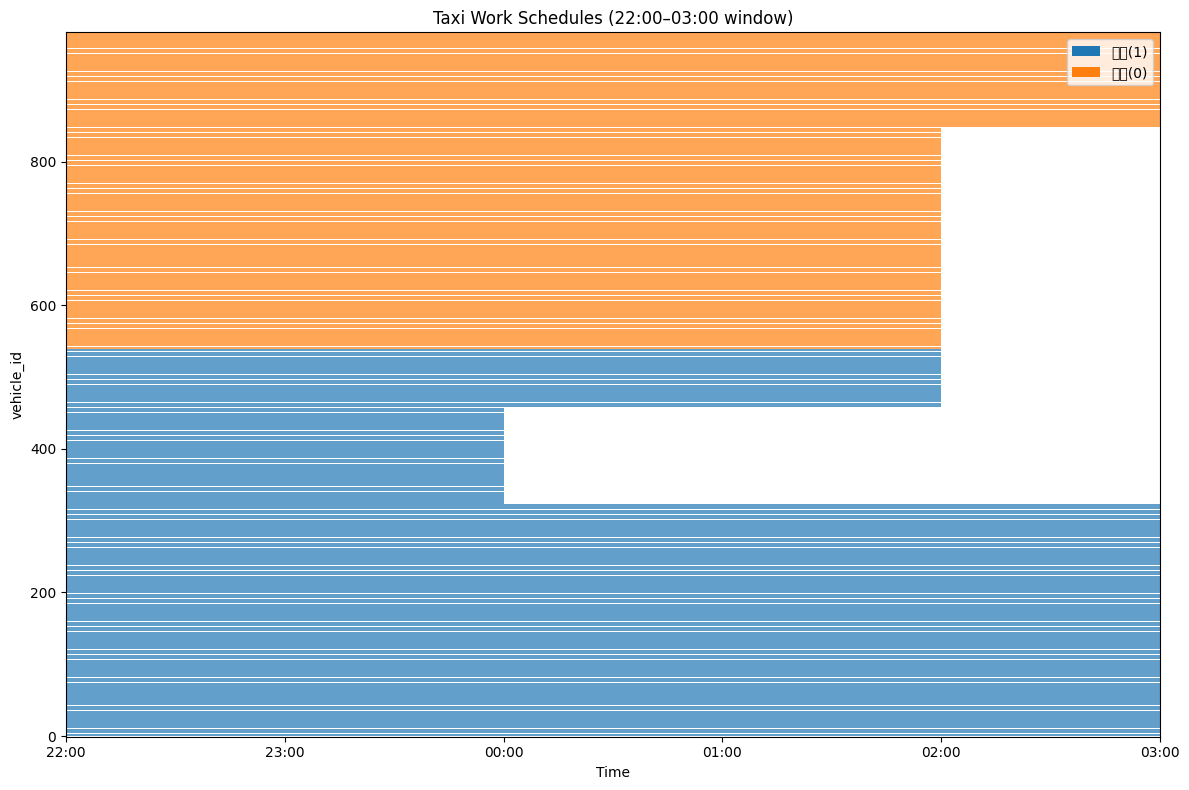

In [64]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plot_df = vehicle_schedule.copy()

# 1) 시간 → 분 변환
plot_df["plot_start"] = (plot_df["work_start"].astype(int) * 60)
plot_df["plot_end"]   = (plot_df["work_end"].astype(int)   * 60)

# 2) 자정 넘김 보정 (예: 20→04, 22→02 등)
cross_midnight = plot_df["plot_end"] < plot_df["plot_start"]
plot_df.loc[cross_midnight, "plot_end"] += 1440

# 3) 보기 좋게 vehicle_id로 정렬(선택)
plot_df = plot_df.sort_values(["taxi_type","vehicle_id"]).reset_index(drop=True)

# 4) 그리기: x축 22:00~03:00 (분 단위)
xmin, xmax = 22*60, 3*60 + 1440  # 1320 ~ 1620

fig, ax = plt.subplots(figsize=(12, 8))

colors = {1: "tab:blue", 0: "tab:orange"}  # 법인=파랑, 개인=주황
for _, r in plot_df.iterrows():
    ax.barh(
        y=r["vehicle_id"],
        width=r["plot_end"] - r["plot_start"],
        left=r["plot_start"],
        height=0.9,
        edgecolor="none",
        alpha=0.7,
        color=colors.get(r["taxi_type"], "gray"),
    )

ax.set_xlim(xmin, xmax)
ax.set_ylim(-1, len(plot_df))

# x축 눈금: 22:00~03:00
xticks = [1320, 1380, 1440, 1500, 1560, 1620]
ax.set_xticks(xticks)
ax.set_xticklabels(["22:00","23:00","00:00","01:00","02:00","03:00"])

ax.set_title("Taxi Work Schedules (22:00–03:00 window)")
ax.set_xlabel("Time")
ax.set_ylabel("vehicle_id")

# 간략 범례
from matplotlib.patches import Patch
legend_elems = [Patch(facecolor="tab:blue", label="법인(1)"),
                Patch(facecolor="tab:orange", label="개인(0)")]
ax.legend(handles=legend_elems, loc="upper right")

plt.tight_layout()
plt.show()

#### 초기 위치 랜덤생성 확인

In [65]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import folium

# 0) 경계 로드
sgn = gpd.read_file(boundary_path)
sgn_union = sgn.unary_union  # Polygon or MultiPolygon (EPSG:4326 가정)

# 1) vehicle_schedule -> GeoDataFrame (lon, lat 순서 주의)
vs = vehicle_schedule.dropna(subset=["lat","lon"]).copy()
vs_gdf = gpd.GeoDataFrame(
    vs,
    geometry=gpd.points_from_xy(vs["lon"], vs["lat"]),
    crs="EPSG:4326"
)

# 2) 성남시 내부 여부 판정
vs_gdf["inside"] = vs_gdf.within(sgn_union)
print("총 차량:", len(vs_gdf))
print("성남 경계 내부:", int(vs_gdf["inside"].sum()))
print("성남 경계 외부:", int((~vs_gdf["inside"]).sum()))

# 3) 지도 시각화 (표본 1,000개까지 표시: 너무 많으면 느려짐)
sample = vs_gdf.sample(min(1000, len(vs_gdf)), random_state=42)

m = folium.Map(location=[37.4200, 127.1265], zoom_start=12, tiles="cartodbpositron")
folium.GeoJson(sgn.to_json(), name="Seongnam Boundary").add_to(m)

for _, r in sample.iterrows():
    color = "green" if r["inside"] else "red"
    folium.CircleMarker(
        location=[r["lat"], r["lon"]],
        radius=2, color=color, fill=True, fill_opacity=0.7,
        popup=f"veh {r['vehicle_id']} | cartype={r['cartype']} | {r['work_start']:02d}-{r['work_end']:02d}"
    ).add_to(m)

m  # 주피터/노트북에서 지도 출력

총 차량: 980
성남 경계 내부: 980
성남 경계 외부: 0


In [66]:
vehicle_schedule

vehicle_id  taxi_type  work_start  work_end  temporary_stopTime  \
0             0          1          20         4                   0   
1             1          1          20         4                   0   
2             2          1          20         4                   0   
3             3          1          20         4                   0   
4             4          1          20         4                   0   
..          ...        ...         ...       ...                 ...   
975         975          0          22         3                   0   
976         976          0          22         3                   0   
977         977          0          22         3                   0   
978         978          0          22         3                   0   
979         979          0          22         3                   0   

           lat         lon  cartype  
0    37.457352  127.169044        0  
1    37.369964  127.049223        0  
2    37.441287  127.163614        0  
3    37.429519  127.058490        0  
4    37.438641  127.087444        0  
..         ...         ...      ...  
975  37.430373  127.170107        0  
976  37.378556  127.160974        0  
977  37.437363  127.108137        0  
978  37.430616  127.071539        0  
979  37.446466  127.166712        0  

[980 rows x 8 columns]

In [67]:
# # work_end < work_start인 경우 익일 종료로 처리
# vehicle_schedule.loc[vehicle_schedule['work_end'] < vehicle_schedule['work_start'], 'work_end'] += 24

In [68]:
vehicle_schedule

vehicle_id  taxi_type  work_start  work_end  temporary_stopTime  \
0             0          1          20         4                   0   
1             1          1          20         4                   0   
2             2          1          20         4                   0   
3             3          1          20         4                   0   
4             4          1          20         4                   0   
..          ...        ...         ...       ...                 ...   
975         975          0          22         3                   0   
976         976          0          22         3                   0   
977         977          0          22         3                   0   
978         978          0          22         3                   0   
979         979          0          22         3                   0   

           lat         lon  cartype  
0    37.457352  127.169044        0  
1    37.369964  127.049223        0  
2    37.441287  127.163614        0  
3    37.429519  127.058490        0  
4    37.438641  127.087444        0  
..         ...         ...      ...  
975  37.430373  127.170107        0  
976  37.378556  127.160974        0  
977  37.437363  127.108137        0  
978  37.430616  127.071539        0  
979  37.446466  127.166712        0  

[980 rows x 8 columns]

In [69]:
vehicle_schedule.to_csv("data/agents/vehicle/vehicle_data.csv", index=False)
print("vehicle_data.csv 저장 완료 (덮어쓰기됨)")

vehicle_data.csv 저장 완료 (덮어쓰기됨)
